# Model Training

This notebook contains cleaning the text ingested in the `Data Ingestion` notebook and create supervised machine learning models to understand customer sentiment and evaluate them using a test set. 

### Contents:

1. [Data Exploration](#Data-Exploration)
2. [Text Cleaning](#Cleaning-Text)
3. [Logistic Regression](#Logistic-Regression)
4. [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)


## Importing Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import os
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
cur_dir = os.getcwd()
artifacts_folder = os.path.join(os.path.abspath(os.path.join(cur_dir, os.pardir)),'artifacts')

df = pd.read_csv(artifacts_folder+'/data/data.csv')
df.head()

,target,text
0,0,"Not That Great: Though I love Tito Puente, I w..."
1,1,Loved it right up until the last 10 pages: Thi...
2,1,Great Guide for those who want to know: Great ...
3,0,The Worst Deal yet: This was the worst compute...
4,0,fun for kids but...: My kid wanted to buy mini...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  500000 non-null  int64 
 1   text    500000 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


In [4]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (500000, 2)


# Data Exploration

In [5]:
df.isna().sum()

target    0
text      0
dtype: int64

In [6]:
df.duplicated().sum()

0

### Plotting Value Counts of Sentiments

In [7]:
review_counts = df['target'].value_counts()
review_counts

target
0    250166
1    249834
Name: count, dtype: int64

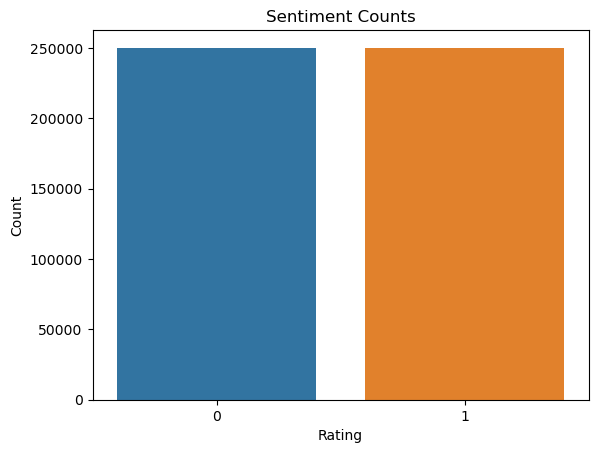

In [8]:
x_ = [str(i) for i in review_counts.index]
y_ = review_counts.values

sns.barplot(x=x_, y=y_)
plt.title('Sentiment Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Cleaning Text

In [12]:
def clean_text(texts):
    cleaned_texts = []
    stopwords_eng = stopwords.words('english')
    count = 0
    for text in texts:
        #removing hyperlinks
        text_ = re.sub(r'https?://[^\s\n\r]+', ' ', text)
        #removing punctuations and digits, only taking words
        text_ = re.sub('[^a-zA-z]', ' ', text_)
        text_ = re.sub(r'[\W_]+', ' ', text_)
        text_ = text_.lower()
        words = nltk.word_tokenize(text_)
        words = [word for word in words if word not in stopwords_eng]
        cleaned_texts.append(' '.join(words))
        count += 1
        if count % 50000 == 0:
            print(f'Cleaned {count} text')
    print(f'Cleaned {count} text')
    print('Completed cleaning text')
    return np.array(cleaned_texts)

In [13]:
texts = df['text'].copy()
texts.head()

0    Not That Great: Though I love Tito Puente, I w...
1    Loved it right up until the last 10 pages: Thi...
2    Great Guide for those who want to know: Great ...
3    The Worst Deal yet: This was the worst compute...
4    fun for kids but...: My kid wanted to buy mini...
Name: text, dtype: object

In [14]:
cleaned_texts = clean_text(texts)

Cleaned 50000 text
Cleaned 100000 text
Cleaned 150000 text
Cleaned 200000 text
Cleaned 250000 text
Cleaned 300000 text
Cleaned 350000 text
Cleaned 400000 text
Cleaned 450000 text
Cleaned 500000 text
Cleaned 500000 text
Completed cleaning text


In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(texts):
    lem_texts = []
    count = 0
    for text in texts:
        lem_words = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
        lem_text = ' '.join(lem_words)
        lem_texts.append(lem_text)
        count += 1
        if count % 50000 == 0:
            print(f'Lemmatized {count} text')
    print(f'Lemmatized {count} text')
    return np.array(lem_texts)

In [17]:
lem_texts = lemmatize_text(cleaned_texts)

Lemmatized 50000 text
Lemmatized 100000 text
Lemmatized 150000 text
Lemmatized 200000 text
Lemmatized 250000 text
Lemmatized 300000 text
Lemmatized 350000 text
Lemmatized 400000 text
Lemmatized 450000 text
Lemmatized 500000 text
Lemmatized 500000 text


In [18]:
text = ' '.join(lem_texts)
chars = set(list(text))
print(chars)

{'p', 'u', 'w', 'm', ' ', 'c', 'b', 'k', 'd', 'r', 'y', 'q', 'e', 'i', 'j', 'z', 'l', 's', 't', 'g', 'n', 'x', 'h', 'f', 'v', 'a', 'o'}


In [19]:
print(f'Number of Words: {len(set(text.split()))}')

Number of Words: 256095


In [20]:
word_counts = Counter(text.split())
top_words = word_counts.most_common(10)
for word, count in top_words:
    print(f' {word} : {count}')

 book : 312442
 one : 200487
 great : 149611
 like : 147563
 good : 144799
 time : 118795
 would : 117215
 get : 108414
 read : 100287
 movie : 98481


### Plotting a word cloud

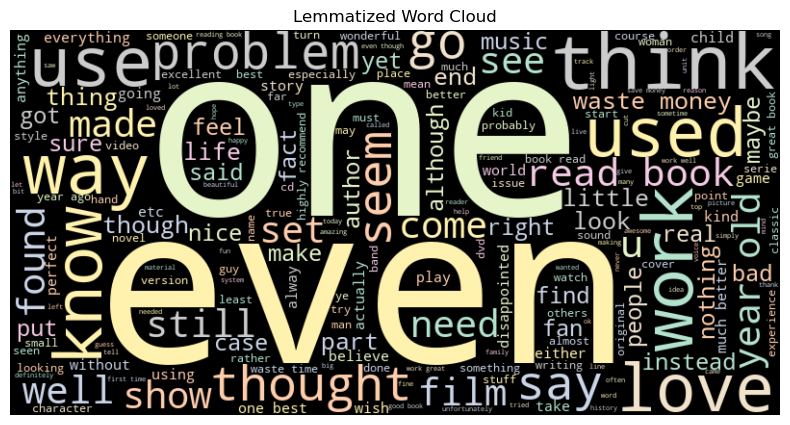

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap='Pastel2').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Lemmatized Word Cloud")
plt.show()

## Spliting into train and test sets

In [23]:
print(f'Length of input: {len(lem_texts)}')
print(f'Length of output: {len(df["target"])}')

Length of input: 500000
Length of output: 500000


**So we have 500000 samples. Splitting in test and train datasets** 

In [26]:
X = np.copy(lem_texts)
y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=10000)

In [27]:
print('Train Sample Size: ', X_train.shape, y_train.shape)
print('Test Sample Size: ', X_test.shape, y_test.shape)

Train Sample Size:  (490000,) (490000,)
Test Sample Size:  (10000,) (10000,)


## Vectorizing Text

In [28]:
tfidf_vec = TfidfVectorizer(max_features = 2000)
tfidf_vec.fit(X_train)

TfidfVectorizer(max_features=2000)

In [29]:
X_train_vec = tfidf_vec.transform(X_train).toarray()
print(f'Length of Vectorized Text Matrix : {X_train_vec.shape}')

Length of Vectorized Text Matrix : (490000, 2000)


### Scaling

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)

# Logistic Regression 

In [31]:
logistic = LogisticRegression(max_iter = 100, multi_class = 'multinomial', C = 0.001)
logistic.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, multi_class='multinomial')

In [51]:
train_score = logistic.score(X_train_scaled, y_train)
print(f'Train Score: {train_score}')

Train Score: 0.8763816326530612


### Evaluating

In [32]:
X_test_vec = tfidf_vec.transform(X_test).toarray()
X_test_scaled = scaler.transform(X_test_vec)

In [34]:
test_score = logistic.score(X_test_scaled, y_test)
print(f'Test Score: {test_score}')

Test Score: 0.8757


### Confusion Matrix and F1 Score

In [46]:
y_pred = logistic.predict(X_test_scaled)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[4398  643]
 [ 600 4359]]


In [48]:
f1_score_ = f1_score(y_test, y_pred)
print(f'F1 score = {f1_score_}')

F1 score = 0.8752133319947797


# Multinomial Naive Bayes

In [40]:
multiNB  = MultinomialNB()
multiNB.fit(X_train_vec, y_train)

MultinomialNB()

In [52]:
train_score = multiNB.score(X_train_scaled, y_train)
print(f'Train Score: {train_score}')

Train Score: 0.8199469387755102


### Evaluating

In [41]:
test_score = multiNB.score(X_test_vec, y_test)
print(f'Test Score: {test_score}')

Test Score: 0.835


### Confusion Matrix and F1 Score

In [49]:
y_pred = multiNB.predict(X_test_vec)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[4194  847]
 [ 803 4156]]


In [50]:
f1_score_ = f1_score(y_test, y_pred)
print(f'F1 score = {f1_score_}')

F1 score = 0.8343706083115839


# Conclusion

The models have great accuracy and f1 score.